In [67]:
import torch
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Patch

In [4]:
dataset = dgl.data.GINDataset("PROTEINS", self_loop=True)

In [5]:
dataset

Dataset("PROTEINS", num_graphs=1113, save_path=/Users/marc/.dgl/PROTEINS_0c2c49a1)

In [6]:
graphs = dataset[:][0]

In [7]:
graphs

[Graph(num_nodes=42, num_edges=204,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=27, num_edges=119,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=10, num_edges=44,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=24, num_edges=116,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=11, num_edges=53,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=336, num_edges=1968,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32)

In [8]:
targets = dataset[:][1]

In [9]:
targets

tensor([0, 0, 0,  ..., 1, 1, 1])

In [10]:
torch.bincount(targets)

tensor([663, 450])

In [11]:
indice = 0
g = graphs[indice]
g, targets[indice]

(Graph(num_nodes=42, num_edges=204,
       ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 tensor(0))

In [12]:
g.ndata['attr']

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [13]:
g.ndata['label']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

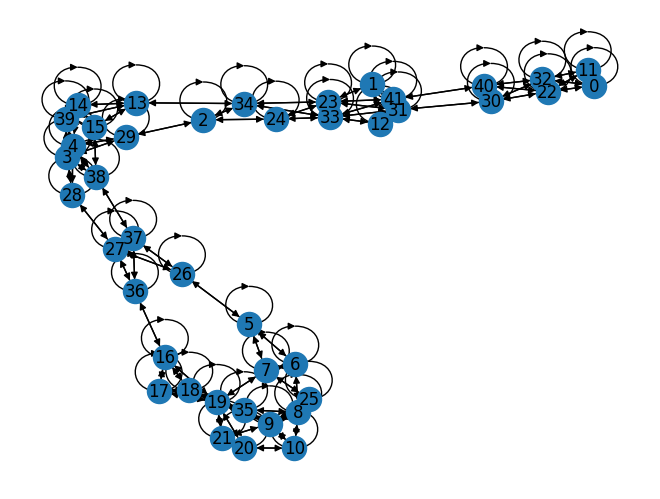

In [14]:
options = {
    #"node_color": "blue",
    #"node_size": 100,
    "width": 1,
}
G = dgl.to_networkx(g)
nx.draw(G,**options,with_labels=True)

In [15]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41))

In [16]:
G.edges()

OutMultiEdgeDataView([(0, 11), (0, 22), (0, 32), (0, 0), (1, 23), (1, 31), (1, 41), (1, 1), (2, 24), (2, 29), (2, 34), (2, 2), (3, 4), (3, 28), (3, 29), (3, 38), (3, 39), (3, 3), (4, 3), (4, 14), (4, 28), (4, 29), (4, 38), (4, 39), (4, 4), (5, 6), (5, 7), (5, 26), (5, 5), (6, 5), (6, 7), (6, 8), (6, 6), (7, 5), (7, 6), (7, 19), (7, 25), (7, 7), (8, 6), (8, 9), (8, 10), (8, 25), (8, 35), (8, 8), (9, 8), (9, 10), (9, 19), (9, 21), (9, 25), (9, 35), (9, 9), (10, 8), (10, 9), (10, 20), (10, 10), (11, 0), (11, 22), (11, 32), (11, 11), (12, 31), (12, 33), (12, 41), (12, 12), (13, 14), (13, 15), (13, 34), (13, 39), (13, 13), (14, 4), (14, 13), (14, 15), (14, 39), (14, 14), (15, 13), (15, 14), (15, 38), (15, 15), (16, 17), (16, 18), (16, 19), (16, 36), (16, 16), (17, 16), (17, 18), (17, 19), (17, 17), (18, 16), (18, 17), (18, 19), (18, 35), (18, 18), (19, 7), (19, 9), (19, 16), (19, 17), (19, 18), (19, 20), (19, 21), (19, 35), (19, 19), (20, 10), (20, 19), (20, 21), (20, 20), (21, 9), (21, 19)

DU VERT => 232 

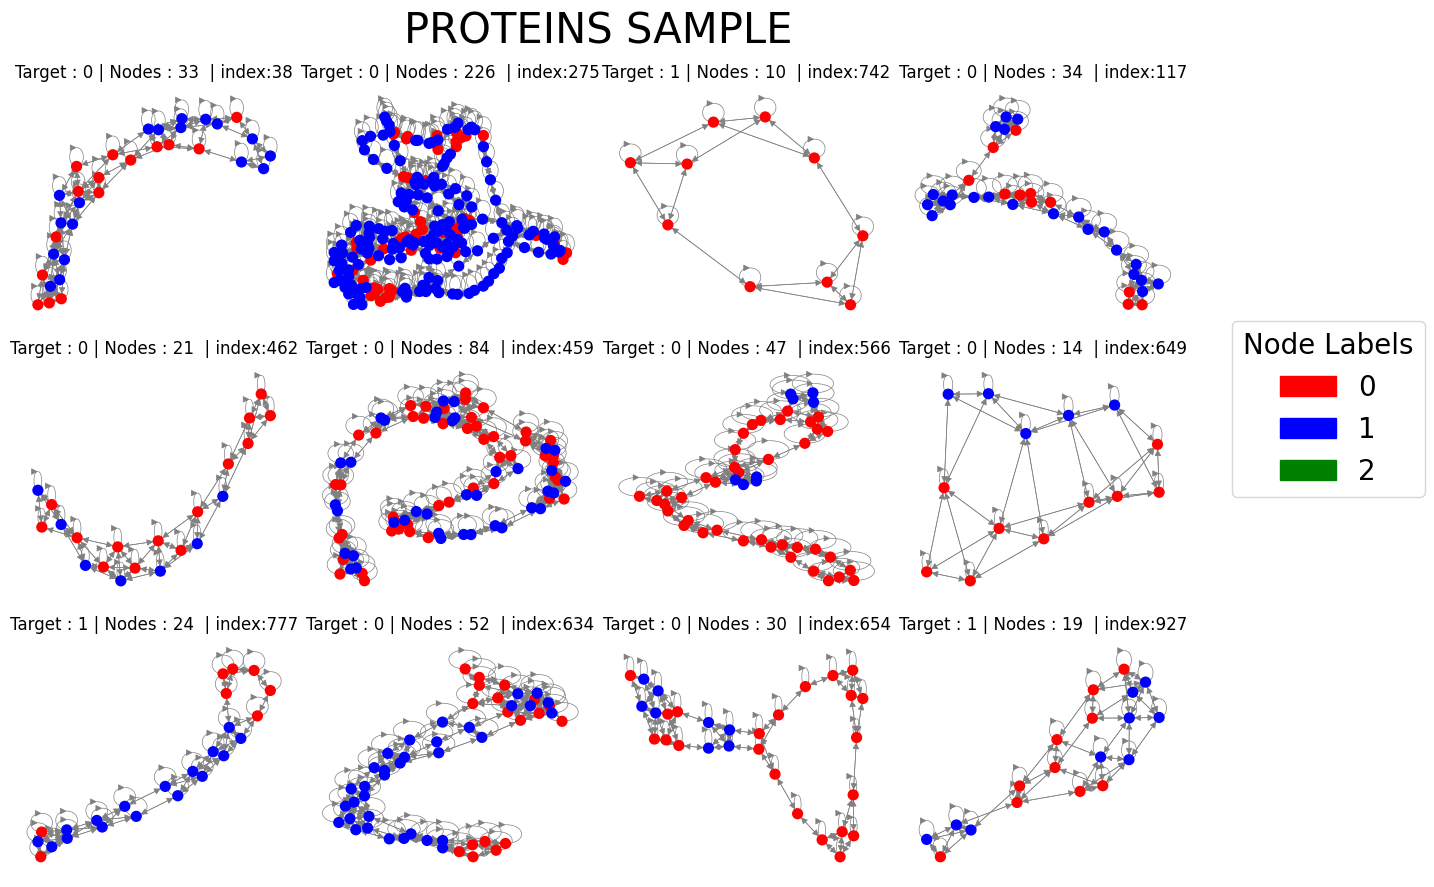

In [95]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle('PROTEINS SAMPLE', fontsize='30')
axes = axes.flatten()
options = {
    "node_size": 50,
    "width": 0.5,
}

for pos in axes:
    random_index = random.randint(0,len(graphs)-1)
    g = graphs[random_index]
    t = targets[random_index]
    labels = g.ndata["label"].numpy()

    label_dict = {i: str(label) for i, label in enumerate(labels)}

    color_dict = {0: "red", 1: "blue", 2: "green"}

    node_colors = [color_dict[label] for label in labels]

    nx.draw(
        g.to_networkx(),
        node_color=node_colors,
        #labels=label_dict,
        #with_labels=True,
        edge_color="gray",
        ax=pos,
        **options
    )
    
    pos.set_title(f'Target : {t} | Nodes : {g.number_of_nodes()}  | index:{random_index}')

plt.tight_layout()
legend_labels = ["0", "1", "2"]
legend_colors = ["red", "blue", "green"]
legend_handles = [
    Patch(color=color, label=label)
    for color, label in zip(legend_colors, legend_labels)
]
plt.figlegend(handles=legend_handles, loc="upper right", title="Node Labels",bbox_to_anchor=(1.2,0.65), fontsize="20", title_fontsize="20")
plt.show()